# GLayout Quick Start Guide




<a href="https://colab.research.google.com/github/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/glayout/GLayout_Cmirror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


```
OpenFASOC Team, Feb 2024
SPDX-License-Identifier: Apache-2.0
```

## Introduction
Welcome!
This notebook serves as an introduction to the GDSFactory-based layout automation tool **GLayout** and a demonstration of the functions and classes you will primarily be using.


## Installation On Google Collab
### 1. Clone the repository and install dependencies
**Python Dependencies**
* [`gdsfactory`](https://github.com/gdsfactory/gdsfactory): Provides the backend for GDS manipulation.
* [`sky130`](https://github.com/gdsfactory/skywater130): The Skywater 130nm PDK Python package for GDSFactory to use in this demo.
* [`gf180`](https://github.com/gdsfactory/gf180): The GF 180nm PDK Python package for GDSFactory to use in this demo.
* [`gdstk`](https://heitzmann.github.io/gdstk/): (installed as a part of gdsfactory) Used for converting GDS files into SVG images for viewing.
* [`svgutils`](https://svgutils.readthedocs.io/en/latest/): To scale the SVG image.

**System Dependencies**
* [`klayout`](https://klayout.de/): For DRC (Design Rule Checking).


#### 1.1. Installing the binary dependency `klayout` using micromamba
**You only need to run this once**

In [1]:
# Setup the environment for the OpenFASOC GDSFactory generator
# You only need to run this block once!

# Clone OpenFASoC
!git clone https://github.com/idea-fasoc/OpenFASOC
# Install python dependencies
!pip install sky130
!pip install gf180 prettyprinttree svgutils
!pip install gdsfactory==7.7.0

import pathlib
import os
# Install KLayout (via conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
# Install from the litex-hub channel
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        klayout


fatal: destination path 'OpenFASOC' already exists and is not an empty directory.
  Using cached gdsfactory-7.26.1-py3-none-any.whl (839 kB)
  Attempting uninstall: gdsfactory
    Found existing installation: gdsfactory 7.16.0
    Uninstalling gdsfactory-7.16.0:
      Successfully uninstalled gdsfactory-7.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gf180 0.1.0 requires gdsfactory<7.17,>=7.16.0, but you have gdsfactory 7.26.1 which is incompatible.
  Using cached gdsfactory-7.16.0-py3-none-any.whl (834 kB)
  Attempting uninstall: gdsfactory
    Found existing installation: gdsfactory 7.26.1
    Uninstalling gdsfactory-7.26.1:
      Successfully uninstalled gdsfactory-7.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sky130 

#### 1.2. Adding the `klayout` binary to the system path, then goto the GLayout directory
**You need to run this each time you restart the kernel**

In [2]:
# Setup the environment for the OpenFASOC GDSFactory generator

# Adding micro-mamba binary directory to the PATH
# This directory contains Klayout
import pathlib
import os
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}
# Add conda packages to the PATH
PATH = os.environ['PATH']
%env PATH={PATH}:{CONDA_PREFIX}/bin

%cd /content/OpenFASOC/openfasoc/generators/glayout

env: CONDA_PREFIX=/content/conda-env
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/conda-env/bin
/content/OpenFASOC/openfasoc/generators/glayout


#### 1.3. Importing Libraries and Utility Functions

In [3]:
from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
from glayout.flow.pdk.gf180_mapped  import gf180_mapped_pdk  as gf180
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)


# Introduction to GLayout

## Overview

This document provides a detailed tutorial on using the GLayout API.

## Prerequisites

Ensure that you have the following installed:
- Python environment with access to GLayout API.
- GDSFactory package for handling generic layout components.
- A PDK (Process Design Kit) appropriate for the technology node you're working on

## GLayers
Processes often have a shared set of layers. We access these layers using generic layers.
We support
1. n well
2. n/p select
3. diffusion
4. poly
5. metal 1
6. metal 2
7. metal 3
8. Mcon
9. via 1
10. via 2

As you can see in the following code examples we use `pdk.get_glayer(<layer name>)` in order to get a tuple associated with a layer.

This tuple associated the generic layer with a PDK's layer.

In [10]:
sky130_met1 = sky130.get_glayer("met1")
gf180_met1 = gf180.get_glayer("met1")
print(sky130_met1)
print(gf180_met1)

(67, 20)
(34, 0)


## GRules
GRules is how you access layout rules for a layer.

### Examples
1. Remember the via example? In that example we wanted to access the minimum width of a via
2. In the via example we want to find the minimum enclosure of a via inside of a metal contact.
3. When you want to space two metal tracks


In [26]:
# Minimum width for a via example
min_width_via1 = sky130.get_grule('via1')['min_width']
print(f"min width for via: {min_width_via1}")

min width for via: 0.17


In [27]:
# Minimum Enclosure Example
# Lets do it for sky 130
min_enc_met1 = sky130.get_grule('via1','met1')['min_enclosure']
min_enc_met2 = sky130.get_grule('via1','met2')['min_enclosure']
print("Sky130")
print(f"min enclosure metal1 and via: {min_enc_met1}")
print(f"min enclosure metal2 and via: {min_enc_met2}")

# Lets do the same for gf180
min_enc_met1 = gf180.get_grule('via1','met1')['min_enclosure']
min_enc_met2 = gf180.get_grule('via1','met2')['min_enclosure']
print("Gf180")
print(f"min enclosure metal1 and via: {min_enc_met1}")
print(f"min enclosure metal1 and via: {min_enc_met2}")

Sky130
min enclosure metal1 and via: 0.0
min enclosure metal2 and via: 0.06
Gf180
min enclosure metal1 and via: 0.12
min enclosure metal1 and via: 0.12


In [30]:
# Minimum Spacing Example
min_met1_spacing = sky130.get_grule('met1','met1')['min_separation']
print(f"min spacing between metal: {min_met1_spacing}")

min spacing between metal: 0.17


## Drawing layouts
We draw rectangles for layers using gdsfactory
For now, lets use the rules we just used to make a very simple metal rectangle. Here we have an example where we draw a simple metal track.

2024-06-19 19:37:26.658 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'metaltrack.gds'


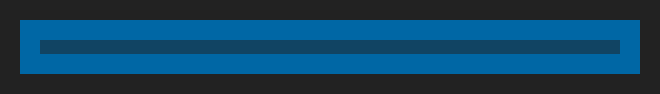

In [41]:
from glayout.flow.pdk.mappedpdk import MappedPDK
from gdsfactory import Component
from gdsfactory.components import rectangle

def makeMet1Rectangle(pdk: MappedPDK, length):
  met1 = pdk.get_glayer("met1")
  met1_width = pdk.get_grule("met1")["min_width"]
  top_level = Component(name="metal_track")
  top_level << rectangle(size=(length, met1_width), layer=met1)
  return top_level

metalTrack = makeMet1Rectangle(sky130,3)
metalTrack.write_gds('metaltrack.gds')
display_gds('metaltrack.gds',scale=20)

## Using and Manipulating Components
In the previous section, we made a component that just consists of a metal track. Now lets use this component to make other components. This is called hierarchal design. Here we introduce the `evaluate_bbox` and `movey`


2024-06-19 20:00:37.397 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'adjmetaltrack.gds'


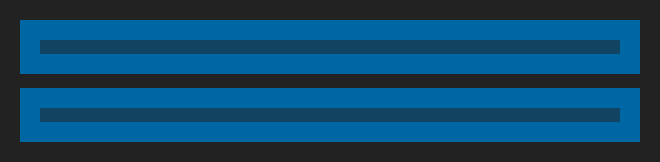

In [48]:
from glayout.flow.pdk.util.comp_utils import evaluate_bbox

def makeAdjacentMetal1Tracks(pdk: MappedPDK, length):
  track1 = makeMet1Rectangle(pdk, length)
  track2 = makeMet1Rectangle(pdk, length)
  top_level = Component(name="adjacent_metal_tracks")
  track1_ref = top_level << track1
  track2_ref = top_level << track2
  width = evaluate_bbox(track1)[1] # gets the dimension on the y axis
  track2_ref.movey(width + pdk.get_grule('met1','met1')['min_separation'])
  return top_level

adjMetalTrack = makeAdjacentMetal1Tracks(sky130,3)
adjMetalTrack.write_gds('adjmetaltrack.gds')
display_gds('adjmetaltrack.gds',scale=20)

## Primitives
GLayout provides many primitives that you can use instead of doing everything from the bottom up. You can find all of the primitives [here](https://github.com/idea-fasoc/OpenFASOC/tree/main/openfasoc/generators/glayout/glayout/flow/primitives)
I will place a pmos and a nmos side by side in the example below:

<ipython-input-53-4a3bc0a4b53a>:15: UserWarning: Unnamed cells, 3 in 'Unnamed_2f8a1aac'
  twoTransistors.write_gds('twotransistors.gds')
2024-06-19 20:04:32.294 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'twotransistors.gds'


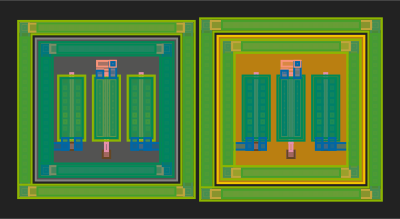

In [53]:
from glayout.flow.primitives.fet import pmos
from glayout.flow.primitives.fet import nmos

def placeTwoTrasistors(pdk):
  pfet = pmos(pdk)
  nfet = nmos(pdk)
  top_level = Component()
  pfet_ref = top_level << pfet
  nfet_ref = top_level << nfet
  compSep = pdk.util_max_metal_seperation()
  nfet_ref.movex(compSep + evaluate_bbox(pfet)[0])
  return top_level

twoTransistors = placeTwoTrasistors(sky130)
twoTransistors.write_gds('twotransistors.gds')
display_gds('twotransistors.gds',scale=2)

## Routing and Ports
How do we connect the ports of transistors. In this section we'll make a current mirror

<ipython-input-57-58a9b6cb3092>:16: UserWarning: Unnamed cells, 3 in 'Unnamed_79c3280c'
  currentMirror(sky130).write_gds("cmirror_example.gds")
2024-06-19 20:52:07.345 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


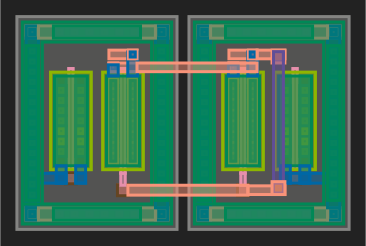

In [57]:
from glayout.flow.routing.straight_route import straight_route
from glayout.flow.routing.c_route import c_route

def currentMirror(pdk: MappedPDK):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(False, True))
  pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(True, False))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_source_E"], cmir_ref.ports["multiplier_0_source_E"])
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_gate_E"], cmir_ref.ports["multiplier_0_gate_E"])
  currMirrComp << c_route(pdk, cref_ref.ports["multiplier_0_drain_E"], cref_ref.ports["multiplier_0_gate_E"])
  return currMirrComp

currentMirror(sky130).write_gds("cmirror_example.gds")
display_gds("cmirror_example.gds")